### Import Libraries

In [1]:
from numpy import zeros
from numpy import ones
import numpy as np
import pandas as pd
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

from sklearn.preprocessing import MinMaxScaler

2022-11-10 17:39:30.371009: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 17:39:30.474701: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-10 17:39:30.502376: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-10 17:39:30.977214: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

### Define Discriminator

In [2]:
def define_discriminator(in_shape=(384,1), n_classes=4):
    # weight initialization
    #init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    # downsample to 14x14
    fe = Conv1D(16, 3, strides=2, padding='same')(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.2)(fe)
    # normal
    fe = Conv1D(32, 3, strides=2, padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.2)(fe)
    # downsample to 7x7
    fe = Conv1D(64, 3, strides=2, padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.2)(fe)
    
    #downsample one more
    fe = Conv1D(128, 3, strides=2, padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.2)(fe)
   
    # flatten feature maps
    fe = Flatten()(fe)
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)
    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    model.summary()
    return model

### Define Generator

In [3]:
def define_generator(latent_dim, n_classes=4):
    # weight initialization
    #init = RandomNormal(stddev=0.02)
    depth = 32 #32
    ks = 3
    dropout = 0.25
    dim = 96 #
    # 
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 96 * 1
    li = Dense(n_nodes)(li)
    
    # reshape to additional channel
    li = Reshape((96, 1, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = dim*depth
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((dim, 1, depth))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li]) #gen=96,1,32 x li=96,1,1
    # upsample to 192,1,16
    gen = Conv2DTranspose(16, 3, strides=(2,1), padding='same')(merge)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    #upsample to  384,1,8
    gen = Conv2DTranspose(8, 3, strides=(2,1), padding='same')(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    #updamsple
    #gen = Conv2DTranspose(48, (3,3), strides=(2,1), padding='same', kernel_initializer=init)(gen)
    #gen = BatchNormalization()(gen)
    #gen = Activation('relu')(gen)
    #384 x 1 property image
    gen = Reshape((384,-1))(gen)
    # upsample to 28x28
    #gen = Conv1DTranspose(1, 3, padding='same', kernel_initializer=init)(gen)
    gen = Conv1D(1, 3, strides=1, padding='same')(gen)
    out_layer = Activation('tanh')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    model.summary()
    return model

### Define Gan

In [4]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
    return model

### Load Images

In [5]:
def load_real_samples():
    # load dataset
    df29 = pd.read_csv('outfinaltest890.csv',header=None)
    
    #df29 = df29.iloc[1:]
    #df = df.astype('float64')
    #data11 = df29.values
    dataset=df29.values
    dataset = dataset.astype('float64')
    dataxy=dataset[:,1:]
    timep=np.zeros([len(dataset),])
    timep=dataset[:,0]
    #maxchannels=10
    maxer=np.amax(dataset[:,2])
    print (maxer)
    maxeri=maxer.astype('int')
    maxchannels=maxeri
    idataset=np.zeros([len(dataset),],dtype=int)
    idataset=dataset[:,2]
    idataset=idataset.astype(int)
    scaler = MinMaxScaler(copy=False)
    
    X_train = dataset[:,1]
    y_train = idataset[:]
    #(X_train, y_train), (_, _) = mnist.load_data()
    window=384
    n = ((np.where(np.any(dataxy, axis=1))[0][-1] + 1) // window) * window
    
    xx = scaler.fit_transform(dataxy[:n,0].reshape(-1,1))
    y_train = dataxy[:(n-window),1].reshape(-1,1)
    
    #make to matrix
    X_train = np.asarray([xx[i:i+window] for i in range (n - window)])
    #y_train = np.asarray([y_train[i:i+window] for i in range (n - window)])
    #trainX=X_train.copy()
    
    X = X_train.copy()
    trainy=y_train.copy()
    #X = xx.copy()
    #(trainXX, trainyy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    #X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    #X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]

### Select Real Images

In [6]:
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

### Generate points in latent space as input for the generator

In [7]:
def generate_latent_points(latent_dim, n_samples, n_classes=4):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples) #check these labels!
    return [z_input, labels]

### Use the generator to generate n fake examples, with class labels

In [8]:
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

### Generate samples and save as a plot and save the model

In [13]:
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    [X, nmn_label], nmn_y = generate_fake_samples(g_model, latent_dim, n_samples) #TODO!:Numan (nmns were _ and _) - change labels in this row and debug!
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # plot images
    for i in range(100):
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(X[i, :], cmap='gray_r')
        #np.savetxt('test_raw_nc%d%d.csv' % (i,step), X[i,:], delimiter=',')
        #np.savetxt('test_cat_nc%d%d.csv' % (i,step), nmn_label[i],delimiter=',')
    # save plot to file
    #np.savetxt('test_raw_nc%d.csv' % (step), X[:,:,0], delimiter=',')
    #np.savetxt('test_cat_nc%d.csv' % (step), nmn_label[:],delimiter=',')
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

### Train the generator and discriminator

In [28]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=64):
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    print('batch per epoch: %d' % bat_per_epo)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    print('number of steps: %d' % n_steps)
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_steps):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
        # update discriminator model weights
        _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
        # generate 'fake' examples
        [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator model weights
        _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
        # prepare points in latent space as input for the generator
        [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
        # summarize loss on this batch
        print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
        # evaluate the model performance every 'epoch'
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model, latent_dim)

### Setting

In [29]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 384, 1)]     0           []                               
                                                                                                  
 conv1d_15 (Conv1D)             (None, 192, 16)      64          ['input_10[0][0]']               
                                                                                                  
 leaky_re_lu_21 (LeakyReLU)     (None, 192, 16)      0           ['conv1d_15[0][0]']              
                                                                                                  
 dropout_12 (Dropout)           (None, 192, 16)      0           ['leaky_re_lu_21[0][0]']         
                                                                                            

/home/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3.0
(99456, 384, 1) (99456, 1)


In [30]:
train(generator, discriminator, gan_model, dataset, latent_dim)

batch per epoch: 1554
number of steps: 7770
1/1 [==============================] - 0s 109ms/step
>1, dr[0.593,1.552], df[1.488,1.455], g[0.669,1.378]
1/1 [==============================] - 0s 17ms/step
>2, dr[0.627,1.771], df[0.960,1.433], g[0.662,1.383]
1/1 [==============================] - 0s 18ms/step
>3, dr[0.391,1.696], df[1.568,1.672], g[0.672,1.402]
1/1 [==============================] - 0s 21ms/step
>4, dr[0.668,1.447], df[1.112,1.872], g[0.678,1.382]
1/1 [==============================] - 0s 18ms/step
>5, dr[0.821,1.535], df[1.259,1.895], g[0.680,1.393]
1/1 [==============================] - 0s 19ms/step
>6, dr[0.635,1.315], df[1.241,1.585], g[0.680,1.384]
1/1 [==============================] - 0s 19ms/step
>7, dr[0.813,1.479], df[1.315,1.766], g[0.683,1.371]
1/1 [==============================] - 0s 19ms/step
>8, dr[0.697,1.586], df[0.968,1.785], g[0.686,1.385]
1/1 [==============================] - 0s 19ms/step
>9, dr[0.565,1.683], df[1.033,1.543], g[0.689,1.394]
1/1 [=====

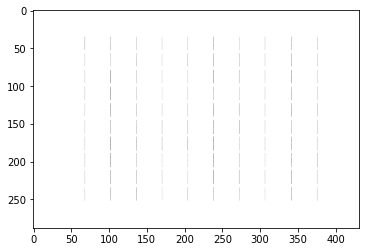

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image

img_test = Image.open('generated_plot_1554.png')
plt.imshow(img_test)
plt.show()

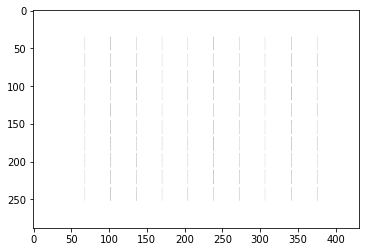

In [32]:
img_test = img.imread('generated_plot_4662.png')
plt.imshow(img_test)
plt.show()

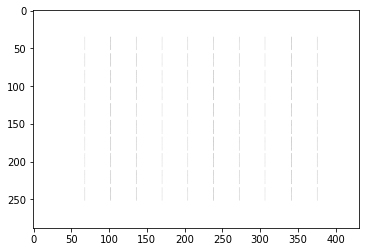

In [34]:
img_test = img.imread('generated_plot_7770.png')
plt.imshow(img_test)
plt.show()